## 1. Time Series Classification Part 1: Feature Creation/Extraction

An interesting task in machine learning is classification of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

### (a) Obtain Data

Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+%5C%28AReM%5C%29



This dataset contains temporal data from a Wireless Sensor Network worn by an actor performing the activities: bending, cycling, lying down, sitting, standing, walking.
It contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

Import packages

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import resample
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings('ignore')

print("========== Packages Imported ==========")

========== Packages Imported ==========


Get the AReM Data Set

Please note that, while importing the dataset and processing it further, I faced a few errors with whitespaces which I resolved manually by fixing the dataset in a text editor.

In [2]:
data_folder_path = "../data/AReM/"

### (b) Splitting Data

Keep datasets 1 and 2 from bending1 and bending2 folders, as well as datasets 1, 2, and 3 from other folders as test data and the remaining datasets as train data.

In [3]:
# Creating empty lists to store all the corresponding file names as per training and testing data.
train_files = []
test_files = []

# Looping through all the files using the walk function.
for dir_path, dirs, files in os.walk(data_folder_path):
    for file in files:
        if "csv" in file:
            file_path = os.path.join(dir_path, file)
            # Checking if the current file path belong to bending1 or bending2 folder.
            if ("bending1" in file_path) or ("bending2" in file_path):
                # Appending to test files list if file is dataset 1 or 2. Else appending to train files list.
                if ("dataset1.csv" in file_path) or ("dataset2.csv" in file_path):
                    test_files.append(file_path)
                else:
                    train_files.append(file_path)
            else:
                # Appending to test files list if file is dataset 1, 2 or 3. Else appending to train files list.
                if ("dataset1.csv" in file_path) or ("dataset2.csv" in file_path) or ("dataset3.csv" in file_path):
                    test_files.append(file_path)
                else:
                    train_files.append(file_path)

print("========== Training and Testing files collected ==========")

========== Training and Testing files collected ==========


### (c) Feature Extraction

Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.  
<br>
<b>i. Research</b>
Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

There are different types of time-domain features. Some of them are:

1) Statistical features: They tell you about the overall distribution of the time series data. Statistical features include the following.
Mean
Median
Standard deviation
variance
first quartile
third quartile
skewness, etc


2) Trend features: They tell you about the overall trend or the direction of the time series. For example, whether the time series is increasing or decreasing. Features include the following. - Slope - Intercept - Change point

3) Cycle features: They tell you about the cyclic or repeating patterns in the time series. The features are as follows. - Period - Amplitude - Phase
However, some of the commonly used features are, maximum, minimum, mean, median, standard deviation, first quartile, third quartile, correlation structure, and distribution.

<b>ii. Extraction</b>  
<br>
Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance.

In [4]:
# The extraction of statistical time-domain features can be easily done using the describe() function.
# However, the format in which the datasets are expected, is a little complicated to achieve.
# For this, I looped through all files, captured their respective description, then re-arranged it in the required format.
# However, this action is performed in several different small steps, each of which has a different function definition.
# But first, let's define some columns that will prove useful for the re-arrangement later.

# The columns to be assigned to the ingested data.
data_columns = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# The columns meant to be given to the describe output. These are arranged to be compatible with the output format of describe function.
describe_stats_columns = ['mean', 'std', 'min', '1st_quartile', 'median', '3rd_quartile', 'max']

# The columns meant to be given to the final dataset output. These are arranged to be compatible with the output format of final datasets.
display_stats_columns = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']

In [5]:
# Function to build label values from directory names.
def get_label_from_directory(file):
    directory_path = os.path.dirname(file)
    directory_as_label = directory_path.split("/")[-1]
    return directory_as_label

# Function to build the stats column for all the time series columns.
def get_stats_columns(stats_columns, split_segments=1):
    end = (6*split_segments) + 1
    describe_cols = []
    for num in range(1, end):
        for stat in stats_columns:
            describe_cols.append("{}_{}".format(stat, num))
    return describe_cols

# Function to extract the statistical features from time series and re-arrange them in required format.
def extract_feature_data(files, display_features, split_segments=1):
    # Empty list to store all the 88 file instances.
    instances_list = []

    # Empty list to store labels (from directory name) from every file instance.
    labels_list = []

    # Looping through all the files.
    for file in files:
        labels_list.append(get_label_from_directory(file))

        # Skipping the top 5 rows, as the actual data starts from 6th row.
        # Also, I read in the read_csv() documentation that when sep is None, python parsing-
        # engine automatically detects the delimiter using the csv.Sniffer tool. Amazing!
        # Also, please note that I had kept on_bad_lines as "error" deliberately so that I could manually fix all the errors.
        file_df = pd.read_csv(file, skiprows=5, sep=None, engine="python", header=None, on_bad_lines="error")
        file_df.columns = data_columns

        # Spliting the time-series into equal segments.
        segment_length = int(file_df.shape[0] / split_segments)
        extracted_features = []
        for i in range(split_segments):
            start = i * segment_length
            end = min((i + 1) * segment_length, file_df.shape[0])
            current_segment = file_df[start : end]
            # Extracting statistical features for all columns, then removing "count" feature and the "time" column from description.
            # Then performing a transpose to make stats definitions as columns.
            current_segment_describe = current_segment.describe().drop("count").drop(columns=data_columns[0]).T
            # Flattening the values because we want features for all time series in 1 single row.
            extracted_features.append(current_segment_describe.values.flatten())     
        instances_list.append(np.concatenate(extracted_features))
            
    # Creating a dataframe out of all obtained instances and then re-arranging it to bring required output format.
    extracted_feature_df = pd.DataFrame(instances_list)
    extracted_feature_df.columns = get_stats_columns(describe_stats_columns, split_segments)
    extracted_feature_df = extracted_feature_df.loc[:, display_features]
    
    # Adding label column for additional intuition.
    extracted_feature_df["label"] = pd.Series(labels_list)
    return extracted_feature_df

In [6]:
train_data = extract_feature_data(train_files, get_stats_columns(display_stats_columns))
print("\nTrain data shape:", train_data.shape, "\n")
train_data.head()


Train data shape: (69, 43) 



min_1  max_1     mean_1  median_1     std_1  1st_quartile_1  \
0  35.00  47.40  43.954500     44.33  1.558835           43.00   
1  33.00  47.75  42.179812     43.50  3.670666           39.15   
2  33.00  45.75  41.678063     41.75  2.243490           41.33   
3  37.00  48.00  43.454958     43.25  1.386098           42.50   
4  36.25  48.00  43.969125     44.50  1.618364           43.31   

   3rd_quartile_1  min_2  max_2    mean_2  ...  1st_quartile_5  \
0           45.00    0.0   1.70  0.426250  ...         35.3625   
1           45.00    0.0   3.00  0.696042  ...         30.4575   
2           42.75    0.0   2.83  0.535979  ...         28.4575   
3           45.00    0.0   1.58  0.378083  ...         22.2500   
4           44.67    0.0   1.50  0.413125  ...         20.5000   

   3rd_quartile_5  min_6  max_6    mean_6  median_6     std_6  1st_quartile_6  \
0           36.50    0.0   1.79  0.493292      0.43  0.513506            0.00   
1           36.33    0.0   2.18  0.613521      0.50  0.524317            0.00   
2           31.25    0.0   1.79  0.383292      0.43  0.389164            0.00   
3           24.00    0.0   5.26  0.679646      0.50  0.622534            0.43   
4           23.75    0.0   2.96  0.555312      0.49  0.487826            0.00   

   3rd_quartile_6     label  
0            0.94  bending1  
1            1.00  bending1  
2            0.50  bending1  
3            0.87  bending1  
4            0.83  bending1  

[5 rows x 43 columns]

In [7]:
test_data = extract_feature_data(test_files, get_stats_columns(display_stats_columns))
print("\nTest data shape:", test_data.shape, "\n")
test_data.head()


Test data shape: (19, 43) 



min_1  max_1     mean_1  median_1     std_1  1st_quartile_1  \
0  37.25  45.00  40.624792     40.50  1.476967         39.2500   
1  38.00  45.67  42.812812     42.50  1.435550         42.0000   
2  12.75  51.00  24.562958     24.25  3.737514         23.1875   
3   0.00  42.75  27.464604     28.00  3.583582         25.5000   
4  24.25  45.00  37.177042     36.25  3.581301         34.5000   

   3rd_quartile_1  min_2  max_2    mean_2  ...  1st_quartile_5  \
0           42.00    0.0   1.30  0.358604  ...           33.00   
1           43.67    0.0   1.22  0.372437  ...           32.00   
2           26.50    0.0   6.87  0.590833  ...           20.50   
3           30.00    0.0   7.76  0.449708  ...           15.00   
4           40.25    0.0   8.58  2.374208  ...           17.95   

   3rd_quartile_5  min_6  max_6    mean_6  median_6     std_6  1st_quartile_6  \
0           36.00    0.0   1.92  0.570583      0.43  0.582915            0.00   
1           34.50    0.0   3.11  0.571083      0.43  0.601010            0.00   
2           27.00    0.0   4.97  0.700188      0.50  0.693720            0.43   
3           20.75    0.0   6.76  1.122125      0.83  1.012342            0.47   
4           21.75    0.0   9.34  2.921729      2.50  1.852600            1.50   

   3rd_quartile_6     label  
0            1.30  bending1  
1            1.30  bending1  
2            0.87  bending2  
3            1.30  bending2  
4            3.90   cycling  

[5 rows x 43 columns]

<b>iii. Standard Deviation</b>  
<br>
Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [8]:
# Standard deviation of train and test data features.
std_dev_df = pd.DataFrame({"Features": get_stats_columns(display_stats_columns), 
                           "Standard_deviation_for_train_data": train_data.describe().loc['std'].values.flatten(), 
                           "Standard_deviation_for_test_data": test_data.describe().loc['std'].values.flatten()}).set_index("Features")

std_dev_df

Standard_deviation_for_train_data  \
Features                                            
min_1                                    8.794295   
max_1                                    4.429182   
mean_1                                   4.917717   
median_1                                 4.956111   
std_1                                    1.758629   
1st_quartile_1                           5.731262   
3rd_quartile_1                           4.783645   
min_2                                    0.000000   
max_2                                    5.147841   
mean_2                                   1.600661   
median_2                                 1.436903   
std_2                                    0.902769   
1st_quartile_2                           0.952201   
3rd_quartile_2                           2.158258   
min_3                                    3.053869   
max_3                                    4.759853   
mean_3                                   3.863304   
median_3                                 3.845730   
std_3                                    0.996008   
1st_quartile_3                           4.145255   
3rd_quartile_3                           3.946023   
min_4                                    0.000000   
max_4                                    2.302408   
mean_4                                   1.179781   
median_4                                 1.149585   
std_4                                    0.473525   
1st_quartile_4                           0.842771   
3rd_quartile_4                           1.566564   
min_5                                    5.368786   
max_5                                    5.449726   
mean_5                                   5.120513   
median_5                                 5.267414   
std_5                                    1.057973   
1st_quartile_5                           5.543882   
3rd_quartile_5                           4.957231   
min_6                                    0.051766   
max_6                                    2.540166   
mean_6                                   1.171306   
median_6                                 1.104626   
std_6                                    0.519377   
1st_quartile_6                           0.774233   
3rd_quartile_6                           1.550218   

                Standard_deviation_for_test_data  
Features                                          
min_1                                  12.136206  
max_1                                   4.379342  
mean_1                                  6.790086  
median_1                                7.088085  
std_1                                   1.869285  
1st_quartile_1                          7.673052  
3rd_quartile_1                          6.385720  
min_2                                   0.000000  
max_2                                   4.870395  
mean_2                                  1.500529  
median_2                                1.345903  
std_2                                   0.832472  
1st_quartile_2                          0.941307  
3rd_quartile_2                          2.028482  
min_3                                   2.644618  
max_3                                   5.393220  
mean_3                                  4.588252  
median_3                                4.753522  
std_3                                   0.760779  
1st_quartile_3                          4.554121  
3rd_quartile_3                          5.014339  
min_4                                   0.000000  
max_4                                   1.733937  
mean_4                                  1.146338  
median_4                                1.161705  
std_4                                   0.409008  
1st_quartile_4                          0.867088  
3rd_quartile_4                          1.541943  
min_5                                   8.252947  
max_5                                   6.782153  
mean_5                                  7.366781  


In [9]:
# Bootstrapping is a statistical method that uses resampling to estimate the sampling distribution of a statistic.
# It is a non-parametric method, which means that it does not make any assumptions about the underlying distribution of the data.
# I have used the sklearn resample package to sample the train dataset 1000 times (with replacement).
# Then, the 90% Confidence Interval for standard deviation of each feature can be estimated by taking the-
# 5th and 95th percentiles of the distribution of standard deviations across the resampled datasets.
# Then, we can say that, we can be 90% confident the interval contains the true standard deviation of the population.

# Extracting the features without the larget variable.
target_data = train_data.drop("label", axis=1)
std_devs_list = []

# Taking 1000 samples to calculate their standard deviations. Then appending the result into list.
for sample_instance in range(1000):
    resampled_data = resample(target_data)
    cols_std_dev = resampled_data.apply(lambda column: np.std(column))
    std_devs_list.append(cols_std_dev)

# Creating a dataframe of standard deviations of all 1000 samples and 42 features.
std_devs_df = pd.DataFrame(std_devs_list)
std_devs_df.columns = target_data.columns

# Taking the 5th and 95th percentile to obtain the 90% interval.
ci_90 = std_devs_df.apply(lambda col : (np.percentile(col, 5), np.percentile(col, 95)), axis=0)

# Converting 42 columns to rows for better visuals.
ci_90 = ci_90.T
ci_90.columns = ['Low', 'High']
ci_90

Low      High
min_1           7.470020  9.865743
max_1           3.265238  5.340485
mean_1          4.313381  5.337708
median_1        4.316046  5.423748
std_1           1.525473  1.919688
1st_quartile_1  5.137041  6.132768
3rd_quartile_1  3.906460  5.460400
min_2           0.000000  0.000000
max_2           4.630370  5.469344
mean_2          1.393490  1.723781
median_2        1.231031  1.564531
std_2           0.811074  0.953985
1st_quartile_2  0.811911  1.040003
3rd_quartile_2  1.888990  2.308521
min_3           2.806599  3.196457
max_3           3.921439  5.375835
mean_3          3.202091  4.413393
median_3        3.152764  4.415613
std_3           0.760464  1.173800
1st_quartile_3  3.435331  4.666124
3rd_quartile_3  3.260651  4.516076
min_4           0.000000  0.000000
max_4           2.058076  2.479455
mean_4          1.070773  1.226833
median_4        1.044421  1.197061
std_4           0.430094  0.500763
1st_quartile_4  0.760844  0.884434
3rd_quartile_4  1.424334  1.631524
min_5           3.564796  6.788705
max_5           4.239030  6.312259
mean_5          3.692367  6.264087
median_5        3.752593  6.461757
std_5           0.794087  1.274606
1st_quartile_5  4.041536  6.716916
3rd_quartile_5  3.601888  6.048732
min_6           0.000000  0.087690
max_6           2.201146  2.801679
mean_6          1.062673  1.225866
median_6        0.995163  1.157302
std_6           0.474183  0.547682
1st_quartile_6  0.695058  0.817399
3rd_quartile_6  1.405506  1.617799

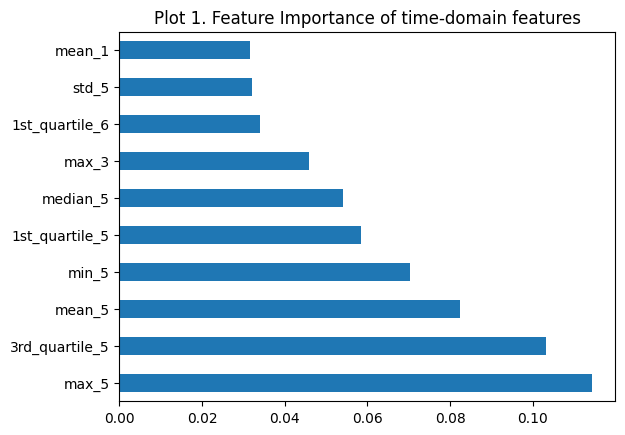

In [10]:
# Split the data into features and target.
X = train_data.drop("label", axis=1)
y = train_data["label"]

# Mapping labels with bending1 and bending2 as 1 and all other labels as 0.
y = y.map({"bending1":1, "bending2":1, "cycling":0, "lying":0, "sitting":0, "standing":0, "walking":0})

# Fitting the ExtraTreesClassifier() to later get feature importance scores.
model = ExtraTreesClassifier(random_state=42)
model.fit(X, y)

# Plotting graph of feature importances for better visualization.
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Plot 1. Feature Importance of time-domain features")
plt.show()

<b>Feature Selection</b>

As per the feature importance plot above, the most important features are:

- max
- mean
- 3rd quartile  
<br>

Hence, selecting these 3 features.

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

Assume that you want to use the training set to classify bending from other
activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. (See
p. 129 of the textbook).

In [11]:
# Funtion to identify our columns of interest in time-series 1, 2, and 6.
# That is, we want max, mean , and 3rd quartile for time-series 1, 2, and 6. 
def identify_columns(tseries, features):
    interest_columns = []
    for series in tseries:
        for feature in features:
            col_name = feature + "_" + str(series)
            interest_columns.append(col_name)
    return interest_columns

# Funtion to encode label column with 1 for bending1 and bending2, and 0 for all other labels.
def get_column_labels(df, interest_columns):
    df.loc[df['label'].isin(['bending1', 'bending2']), 'label'] = 1
    df.loc[df['label'] != 1, 'label'] = 0
    return interest_columns + ['label']

# Function to plot the scatter plot for the relevant features.
def plot_scatter(plot_num, df, hue):
    sns.pairplot(df, hue=hue)
    plt.suptitle("Plot {}. Pairwise Scatter plot of Relevant Features".format(plot_num))
    plt.tight_layout()
    plt.show()

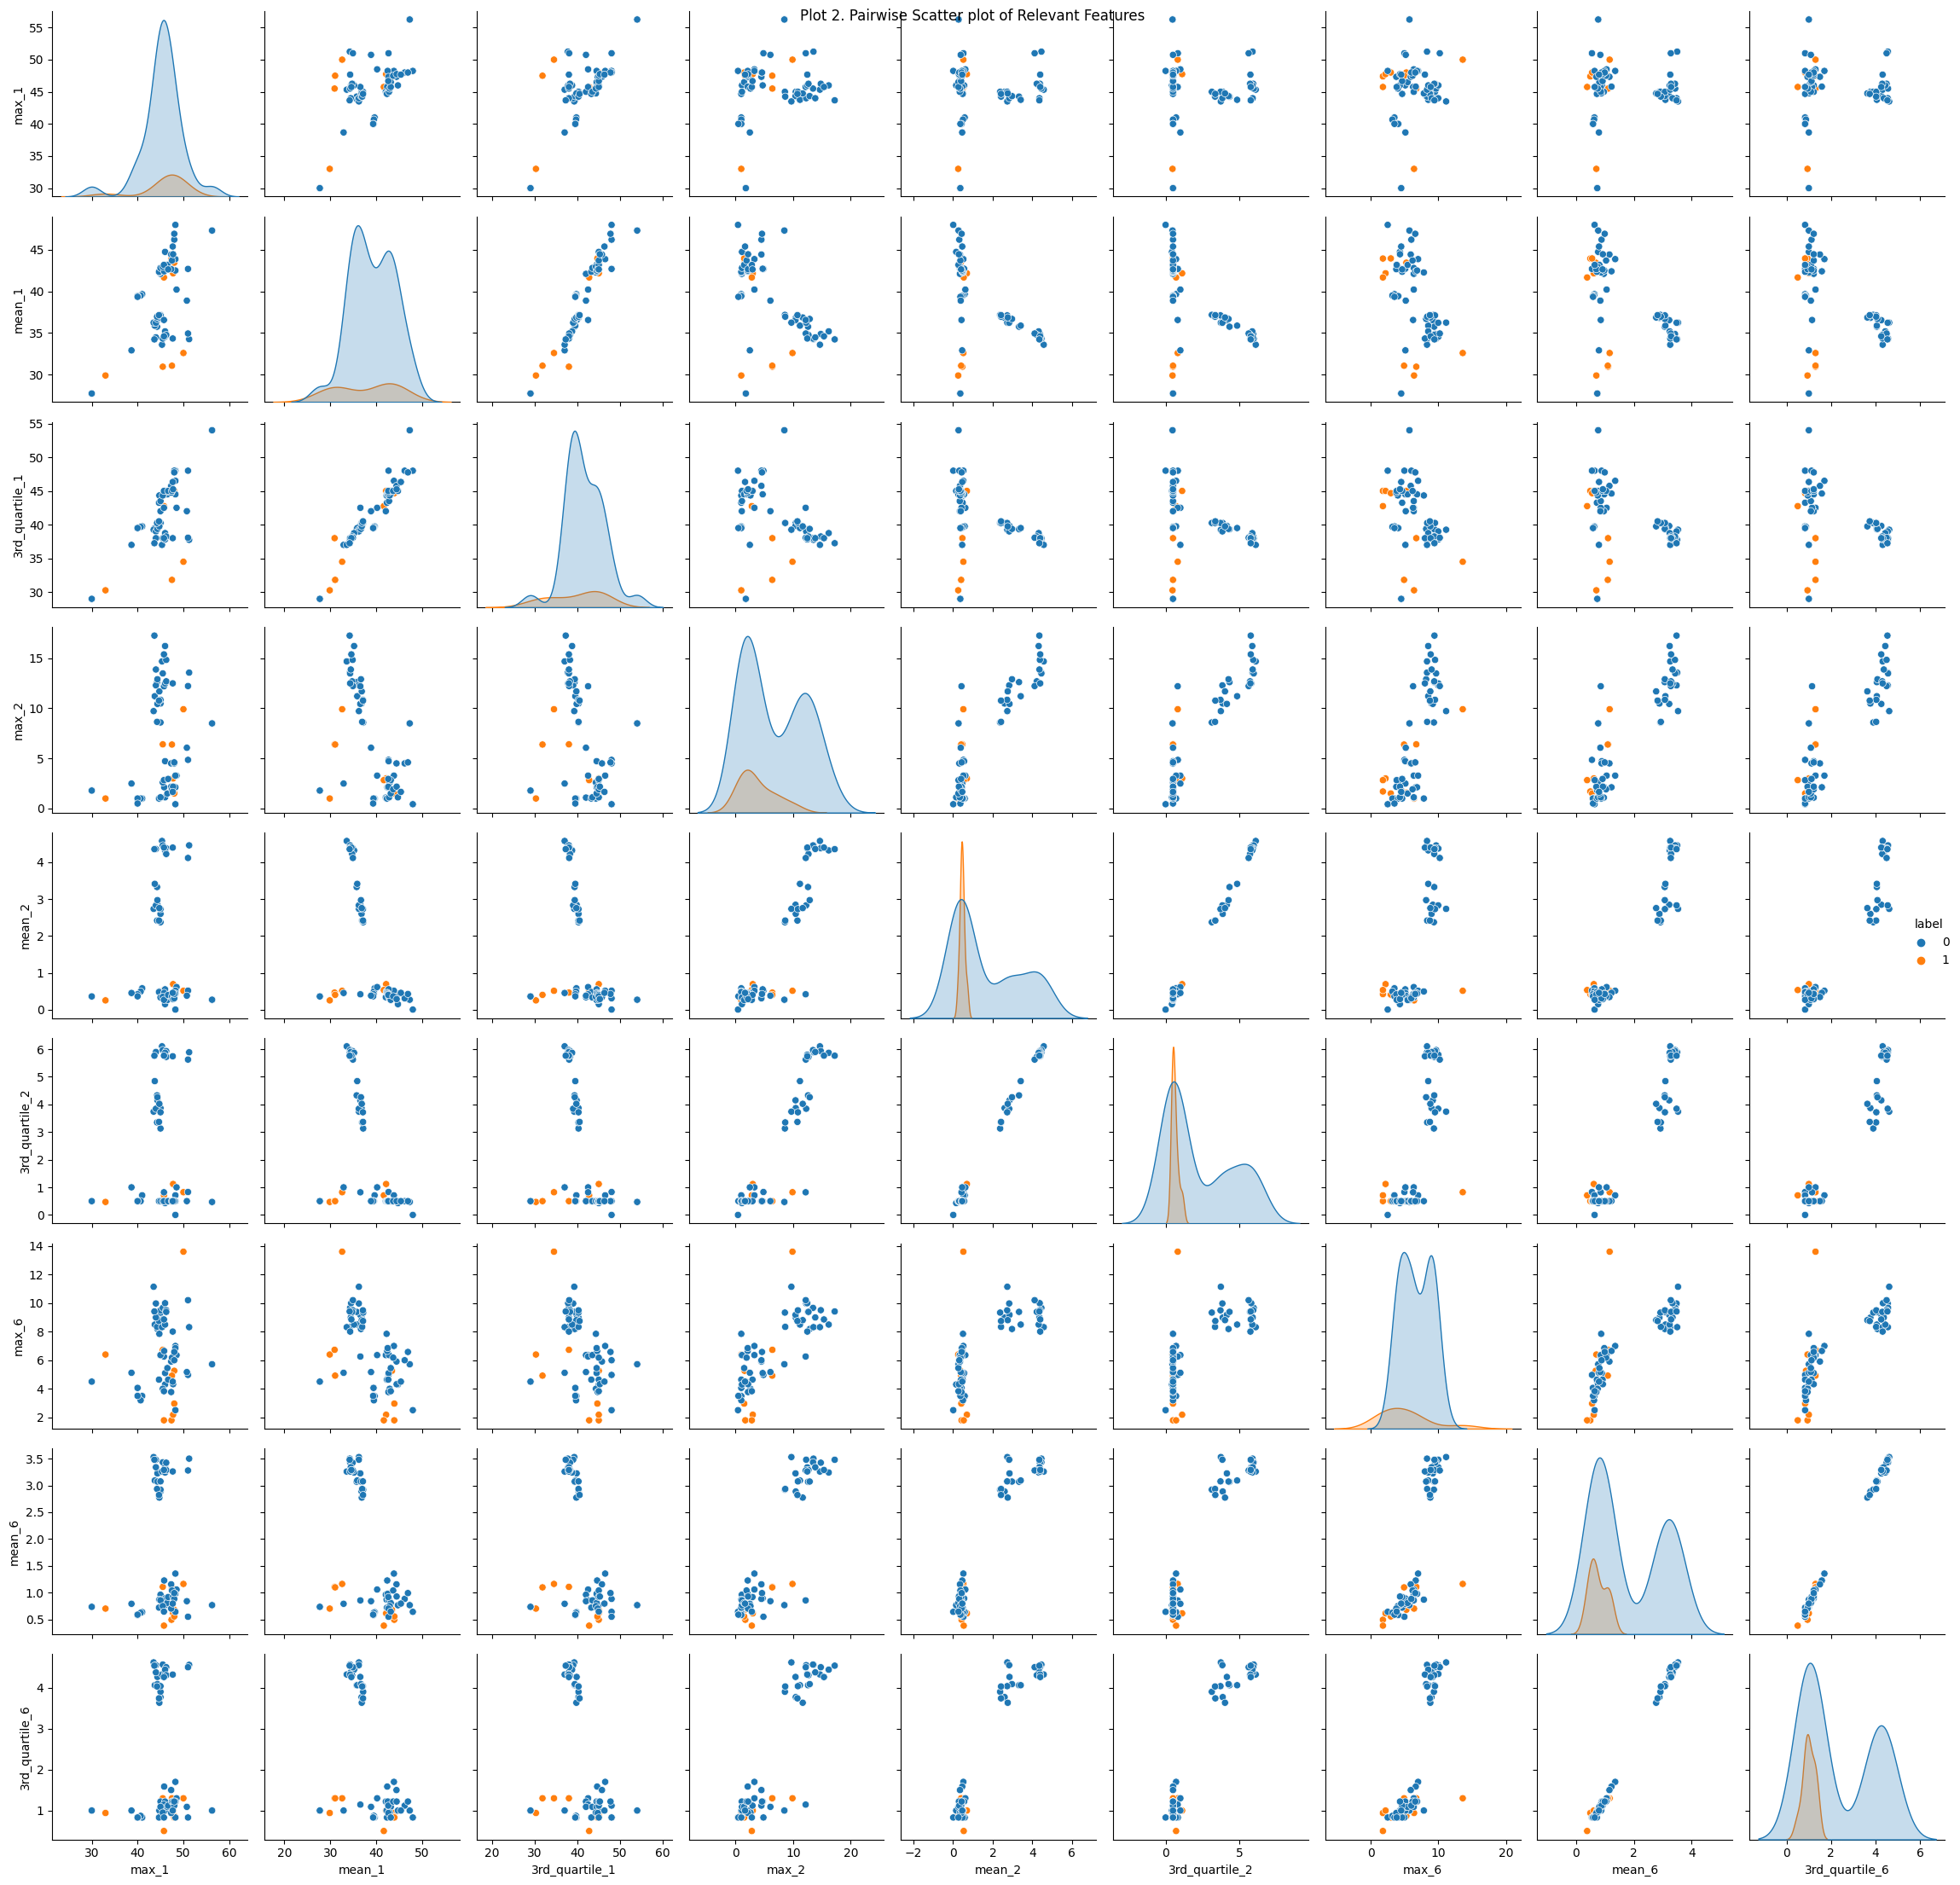

In [12]:
interest_columns = identify_columns([1, 2, 6], ['max', 'mean', '3rd_quartile'])
interest_columns_and_label = get_column_labels(train_data, interest_columns)
interest_df = train_data[interest_columns_and_label]
plot_scatter(2, interest_df, 'label')

#### ii. Splitted Plots

Break each time series in your training set into two (approximately) equal
length time series. Now instead of 6 time series for each of the training
instances, you have 12 time series for each training instance. Repeat the
experiment in 2(a)i, i.e depict scatter plots of the features extracted from both
parts of the time series 1,2, and 6. Do you see any considerable difference in
the results with those of 2(a)i?

In [13]:
# Funtion to convert text labels into binary classified 0 and 1 labels and return the dataframe instead of columns.
def get_column_labels_dataframe(df):
    df.loc[df['label'].isin(['bending1', 'bending2']), 'label'] = 1
    df.loc[df['label'] != 1, 'label'] = 0
    return df

In [14]:
train_data_2 = extract_feature_data(train_files, get_stats_columns(display_stats_columns, split_segments=2), split_segments=2)
train_data_2 = get_column_labels_dataframe(train_data_2)
print("\nTrain data 2 shape:", train_data_2.shape, "\n")
train_data_2.head()


Train data 2 shape: (69, 85) 



min_1  max_1     mean_1  median_1     std_1  1st_quartile_1  \
0  36.50  46.50  44.057167     44.50  1.556971         43.2500   
1  33.75  47.75  43.278875     45.00  3.473355         42.0000   
2  33.00  45.75  41.621208     42.33  3.118644         39.6525   
3  39.00  48.00  44.117042     45.00  1.359836         43.5000   
4  36.67  45.00  43.486208     43.71  1.281976         42.3300   

   3rd_quartile_1  min_2  max_2    mean_2  ...  1st_quartile_11  \
0           45.00    0.0   1.50  0.381042  ...            33.00   
1           45.25    0.0   3.00  0.673292  ...            28.75   
2           44.25    0.0   2.83  0.623083  ...            28.31   
3           45.00    0.0   1.30  0.250042  ...            22.50   
4           44.50    0.0   1.30  0.378667  ...            21.00   

   3rd_quartile_11  min_12  max_12   mean_12  median_12    std_12  \
0          36.2500     0.0    1.50  0.388333       0.00  0.478528   
1          33.7500     0.0    2.18  0.586083       0.47  0.491873   
2          30.5625     0.0    1.50  0.347500       0.43  0.363144   
3          23.7500     0.0    4.06  0.543875       0.50  0.473445   
4          23.5000     0.0    2.96  0.585750       0.50  0.487918   

   1st_quartile_12  3rd_quartile_12  label  
0           0.0000             0.71      1  
1           0.0000             0.87      1  
2           0.0000             0.50      1  
3           0.4300             0.71      1  
4           0.4225             0.83      1  

[5 rows x 85 columns]

In [15]:
test_data_2 = extract_feature_data(test_files, get_stats_columns(display_stats_columns, split_segments=2), split_segments=2)
test_data_2 = get_column_labels_dataframe(test_data_2)
print("\nTest data 2 shape:", test_data_2.shape, "\n")
train_data_2.head()


Test data 2 shape: (19, 85) 



min_1  max_1     mean_1  median_1     std_1  1st_quartile_1  \
0  36.50  46.50  44.057167     44.50  1.556971         43.2500   
1  33.75  47.75  43.278875     45.00  3.473355         42.0000   
2  33.00  45.75  41.621208     42.33  3.118644         39.6525   
3  39.00  48.00  44.117042     45.00  1.359836         43.5000   
4  36.67  45.00  43.486208     43.71  1.281976         42.3300   

   3rd_quartile_1  min_2  max_2    mean_2  ...  1st_quartile_11  \
0           45.00    0.0   1.50  0.381042  ...            33.00   
1           45.25    0.0   3.00  0.673292  ...            28.75   
2           44.25    0.0   2.83  0.623083  ...            28.31   
3           45.00    0.0   1.30  0.250042  ...            22.50   
4           44.50    0.0   1.30  0.378667  ...            21.00   

   3rd_quartile_11  min_12  max_12   mean_12  median_12    std_12  \
0          36.2500     0.0    1.50  0.388333       0.00  0.478528   
1          33.7500     0.0    2.18  0.586083       0.47  0.491873   
2          30.5625     0.0    1.50  0.347500       0.43  0.363144   
3          23.7500     0.0    4.06  0.543875       0.50  0.473445   
4          23.5000     0.0    2.96  0.585750       0.50  0.487918   

   1st_quartile_12  3rd_quartile_12  label  
0           0.0000             0.71      1  
1           0.0000             0.87      1  
2           0.0000             0.50      1  
3           0.4300             0.71      1  
4           0.4225             0.83      1  

[5 rows x 85 columns]

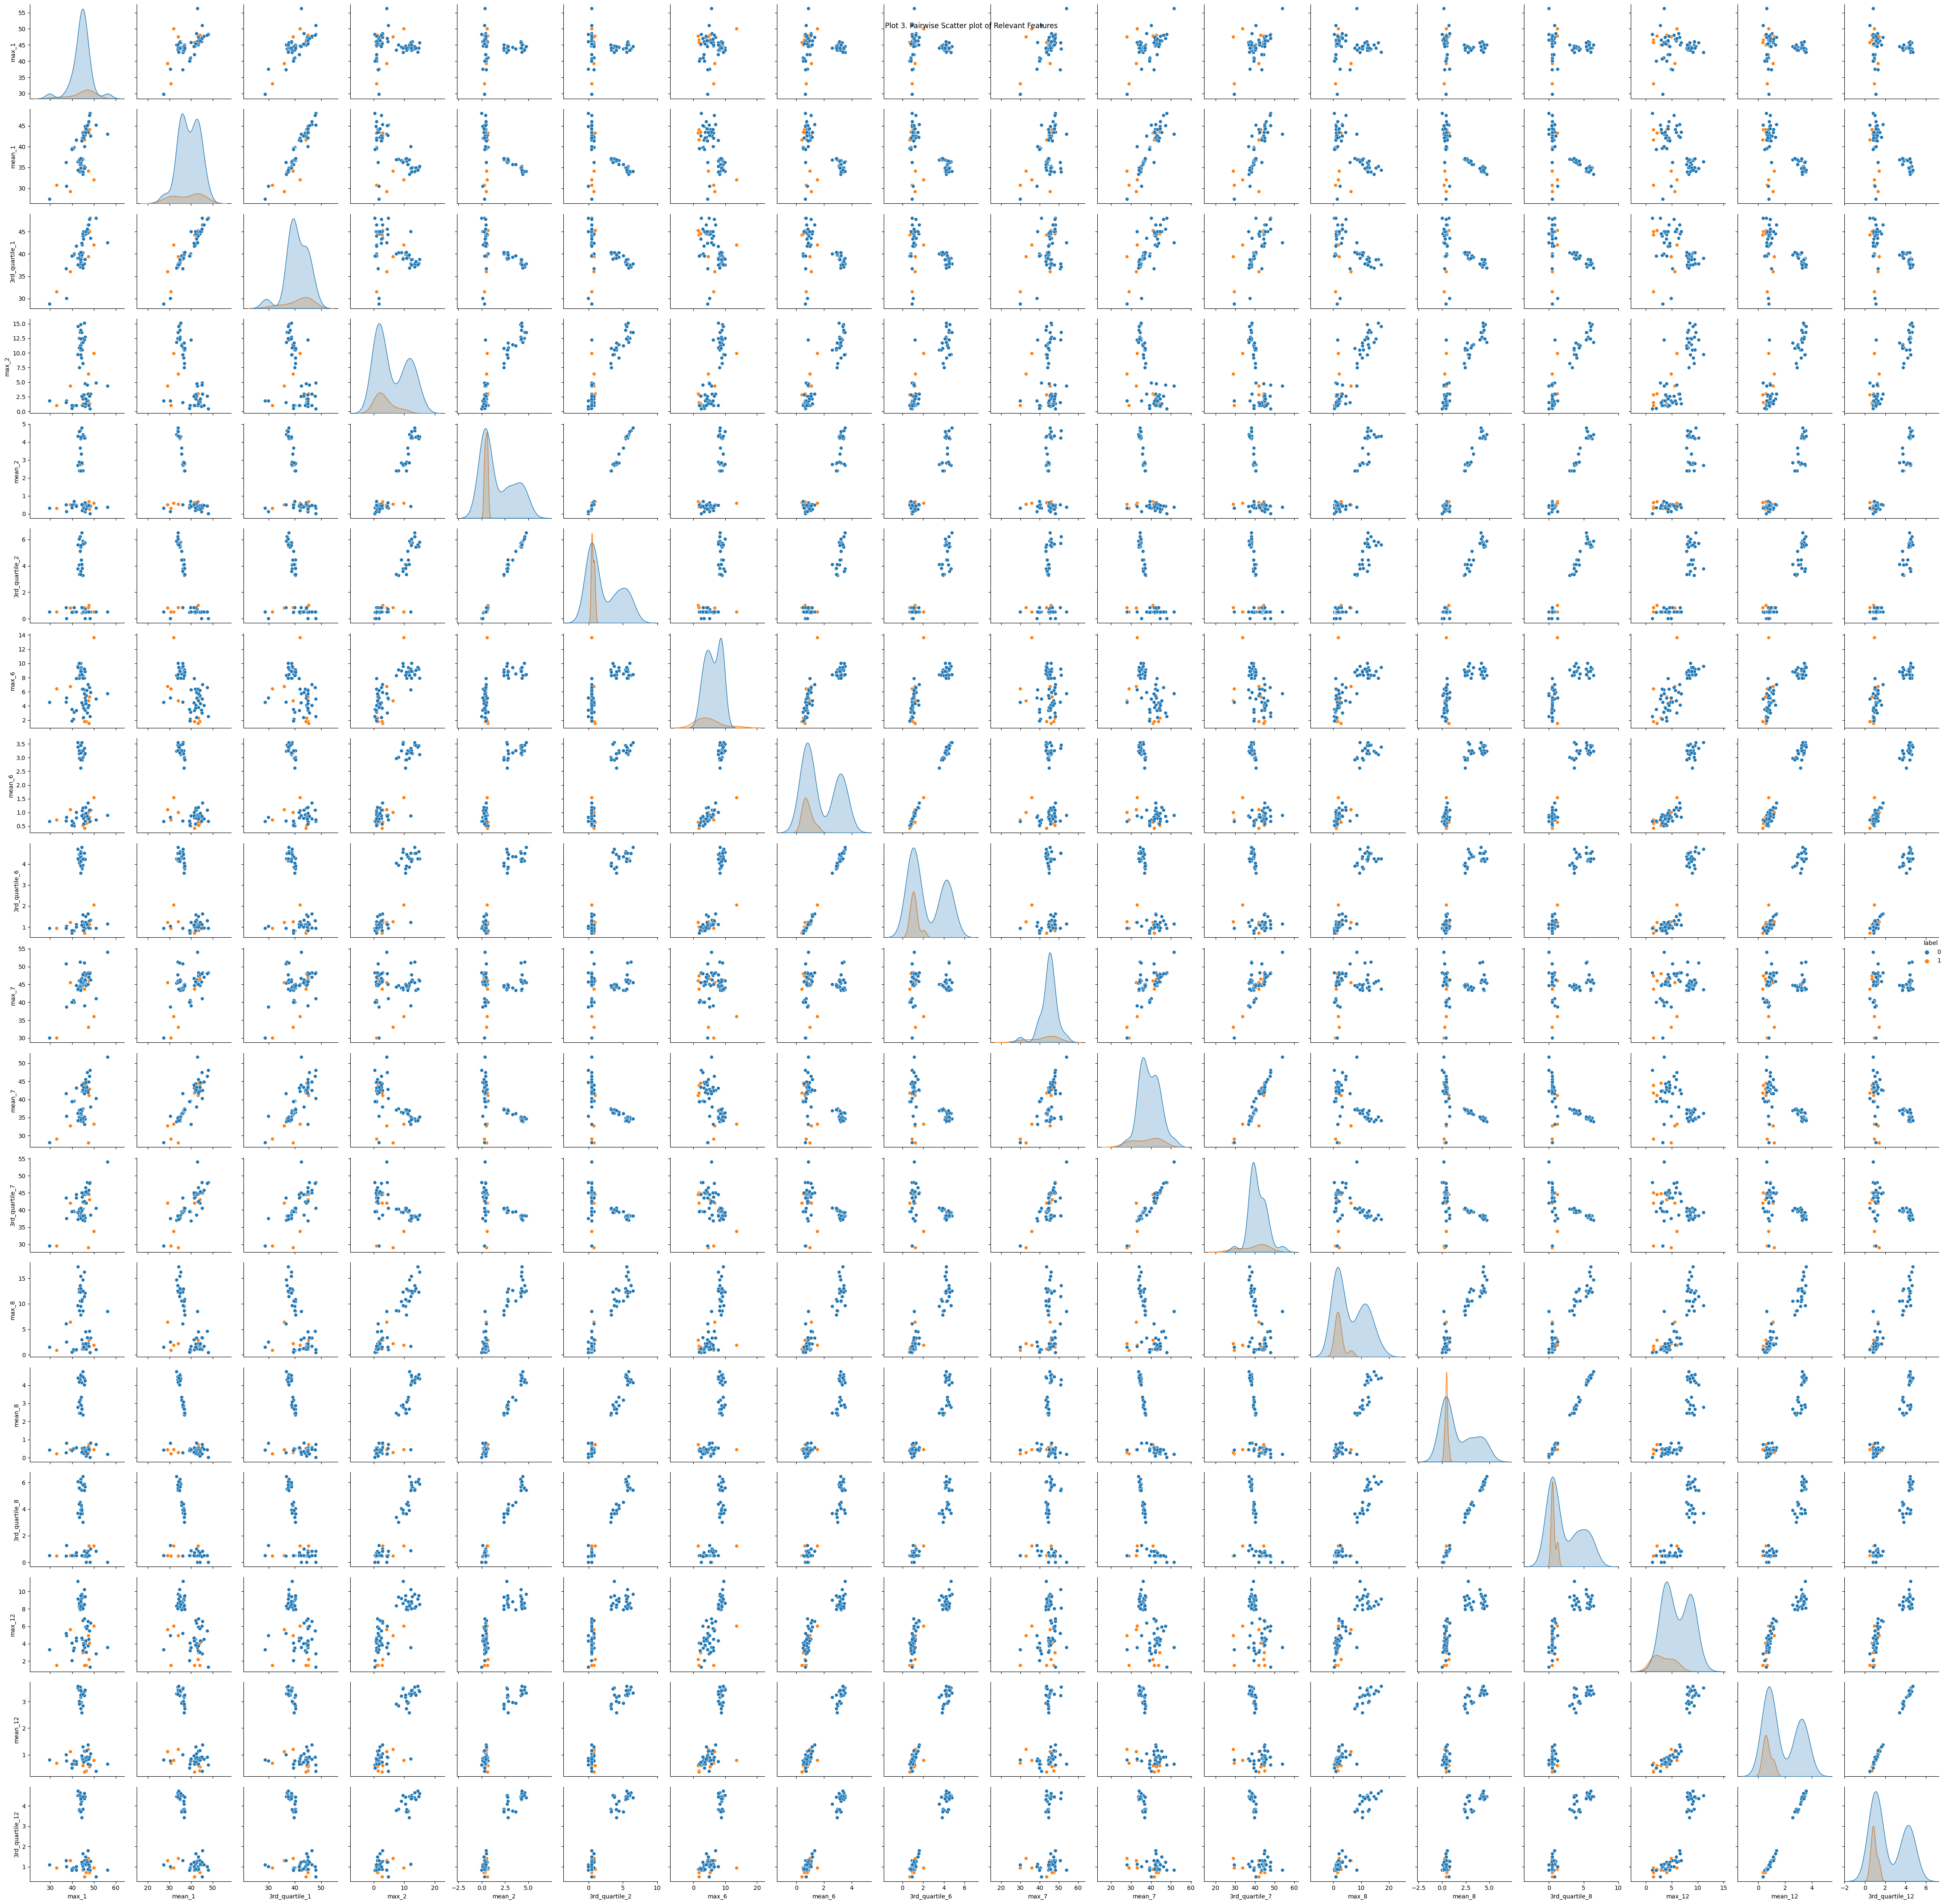

In [16]:
interest_columns_2 = identify_columns([1, 2, 6, 7, 8, 12], ['max', 'mean', '3rd_quartile'])
interest_columns_and_label_2 = get_column_labels(train_data_2, interest_columns_2)
interest_df_2 = train_data_2[interest_columns_and_label_2]
plot_scatter(3, interest_df_2, 'label')

<b>Observation:</b>  
<br>
Although there are minor differences between the two results, the overall distribution of two results is almost same.

#### iii. Time Series Segments

Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series
of approximately equal length and use logistic regression
to solve the binary
classification problem, using time-domain features. Remember that breaking
each of the time series does not change the number of instances. It only
changes the number of features for each instance. Calculate the p-values for
your logistic regression parameters in each model corresponding to each value
of l and refit a logistic regression model using your pruned set of features.
Alternatively, you can use backward selection using sklearn.feature selection
or glm in R. Use 5-fold cross-validation to determine the best value of the pair
(l, p), where p is the number of features used in recursive feature elimination.
Explain what the right way and the wrong way are to perform cross-validation
in this problem. Obviously, use the right way! Also, you may encounter the
problem of class imbalance, which may make some of your folds not having
any instances of the rare class. In such a case, you can use stratified cross
validation. Research what it means and use it if needed.

In [17]:
def convert_text_labels_to_boolean(df):
    temp = df['label']
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = "1"
    df.loc[temp != "1", 'label'] = "0"
    return df
    
# Function to implement oversample on dataset.
def oversample_data(dataset):
    #print("\n========== NOTE ==========\nPerforming oversampling of dataset\n")
    
    label_0_count = dataset.loc[dataset["label"] == "0"].shape[0]
    label_1_count = dataset.loc[dataset["label"] == "1"].shape[0]
    
    if label_0_count > label_1_count:
        minor_label = "1"
        major_label = "0"
    else:
        minor_label = "0"
        major_label = "1"
        
    minor_data = dataset[dataset["label"] == minor_label]
    major_data = dataset[dataset["label"] == major_label]
    
    minor_data = resample(minor_data, replace=True, random_state=60, n_samples=max(label_0_count, label_1_count))
    dataset = pd.concat([major_data, minor_data])
    return dataset

# Function to segregate X data and Y data.
def get_x_y_data(dataset):
    data_x = dataset.iloc[:, :-1]
    data_y = dataset.iloc[:, -1]
    return data_x, data_y

# Funtion to implement Logistic Regression based on fold.
def logistic_regression(train_files, l_val, fold_count, oversample=False, penalty='none'):
    #print("\n========== NOTE ==========\n")
    #print("Executing Logistic Regression with l-value = {}".format(l_val))

    train_df = extract_feature_data(train_files, get_stats_columns(display_stats_columns, split_segments=l_val), split_segments=l_val)
    train_df = convert_text_labels_to_boolean(train_df)
    
    if oversample:
        train_df = oversample_data(train_df)
    
    x_train, y_train = get_x_y_data(train_df)
    if penalty == "l1":
        solver = "liblinear"
    else:
        solver = "lbfgs"
    
    validator = StratifiedKFold(n_splits=fold_count, shuffle=True, random_state=69)
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    selector = RFECV(estimator=model, cv=validator, scoring="accuracy")
    selector.fit(x_train, y_train)
    
    return model, selector

In [18]:
cross_validation_factor = 5
pair_combinations = {
                     "pair(l, p)": [],
                     "score": []}

print("\n========== NOTE ==========\nExecuting Logistic Regression with l-values ∈ {1, 2, 3,. . ., 20}\n")
for l_val in tqdm(range(1, 21), desc="Progress"):
    model, selector = logistic_regression(train_files, l_val, cross_validation_factor, oversample=False)
    nf = selector.n_features_
    score = selector.cv_results_["mean_test_score"].max()
    pair_combinations["pair(l, p)"].append((l_val, nf))
    pair_combinations["score"].append(round(score, 3))

df = pd.DataFrame(pair_combinations).set_index("pair(l, p)")
df


========== NOTE ==========
Executing Logistic Regression with l-values ∈ {1, 2, 3,. . ., 20}



Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [17:32<00:00, 52.63s/it]


score
pair(l, p)       
(1, 6)      1.000
(2, 1)      0.971
(3, 12)     0.971
(4, 1)      0.971
(5, 11)     0.971
(6, 5)      0.986
(7, 14)     0.957
(8, 4)      0.957
(9, 11)     0.957
(10, 19)    0.957
(11, 1)     0.971
(12, 6)     1.000
(13, 12)    1.000
(14, 16)    0.986
(15, 19)    0.986
(16, 13)    1.000
(17, 12)    1.000
(18, 4)     0.986
(19, 5)     0.986
(20, 4)     1.000

<b>Observation:</b>
<br>
- Since we want to let our algorithm gain the knowledge of the various predictors available, therefore, the correct way would be to do the RFE along with Cross Validation.

#### iv. Confusion Matrix

Report the confusion matrix and show the ROC and AUC for your classifier
on train data. Report the parameters of your logistic regression βi
’s as well
as the p-values associated with them.

In [19]:
# Function to get the selected features.
def get_selected_features(features, selector):
    selected_features = []
    for i, feature in enumerate(features):
        if selector.support_[i]:
            selected_features.append(feature)
    return selected_features

# Extracting the selected features as per l-value and fold count.
l_val = 1
fold_count = 5 
features = get_stats_columns(display_stats_columns, split_segments=l_val)
classifier, selector = logistic_regression(train_files, l_val, fold_count)
selected_features = get_selected_features(features, selector)
print("\nFor l-value=1, set of selected features is:", selected_features, "\n")

# Calculation of p-value using statmodels package, as it provides easy way to do so.
train_data = extract_feature_data(train_files, selected_features)
train_data = convert_text_labels_to_boolean(pd.DataFrame(train_data))
x_train, y_train = get_x_y_data(train_data)
const_val = sm.add_constant(x_train.loc[:, selected_features].to_numpy(dtype=float))
model = sm.Logit(y_train.to_numpy(dtype=float), const_val)
summary = model.fit(method='bfgs').summary()
print(summary)


For l-value=1, set of selected features is: ['mean_1', '3rd_quartile_1', 'max_2', 'min_5', 'max_5', '1st_quartile_5'] 

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        02:40:59   Log-Likelihood:            -8.8389e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.9

In [20]:
# Function to plot the ROC and AUC.
def plot_roc_auc(y_actual, y_pred_proba, classifier):
    fig, axes = plt.subplots(figsize=(12, 7))
    axes.set_title("ROC curves")
    
    for i, claas in enumerate(classifier.classes_):
        y_predicted = y_pred_proba[:, i]
        fpr, tpr, thresholds = roc_curve(y_actual, y_predicted, pos_label=claas)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label = "Class: {}; ROC Curve Area: {}".format(claas, round(roc_auc, 4)))
    
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

# Function to perform classification and plot the ROC curve together.
def classification_and_roc_calculation(x_data, y_data, selected_features, isTest=False):
    if not isTest:
        classifier.fit(x_data.loc[:, selected_features], y_data.to_numpy(dtype="int"))
    y_predict = classifier.predict(x_data.loc[:, selected_features])   
    y_pred_proba = classifier.predict_proba(x_data.loc[:, selected_features])
    
    y_true = y_data.to_numpy(dtype=float)
    y_pred = y_predict.round()
    
    cf_mat = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", cf_mat)

    plot_roc_auc(y_true, y_pred_proba, classifier)


Confusion Matrix:
 [[60  0]
 [ 0  9]]


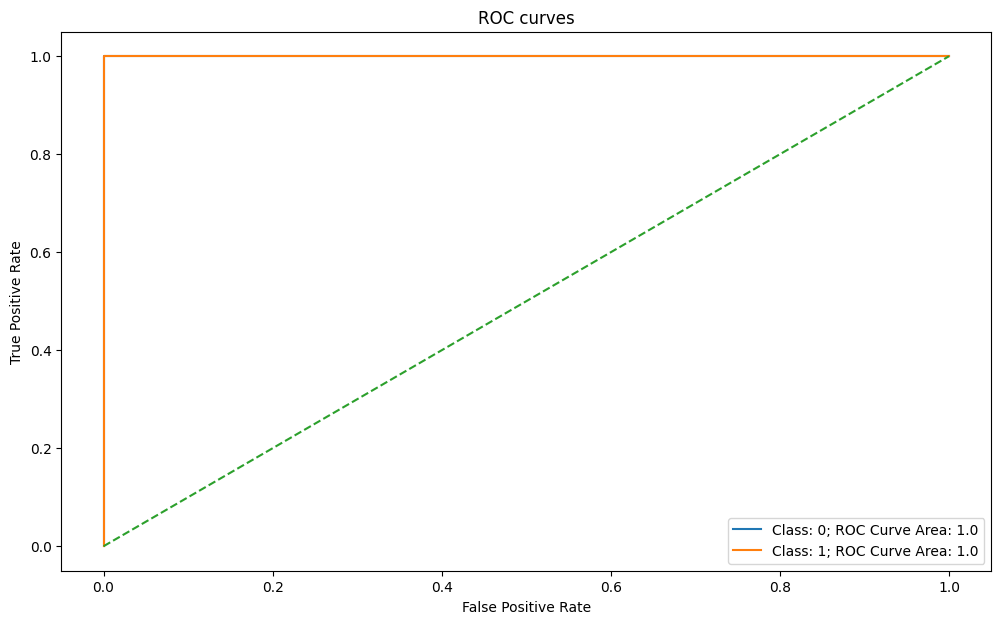

In [21]:
classification_and_roc_calculation(x_train, y_train, selected_features)

#### v. Test Classifier

Test the classifier on the test set. Remember to break the time series in
your test set into the same number of time series into which you broke your
training set. Remember that the classifier has to be tested using the features
extracted from the test set. Compare the accuracy on the test set with the
cross-validation accuracy you obtained previously.

In [22]:
test_data = extract_feature_data(test_files, selected_features)
test_data = convert_text_labels_to_boolean(pd.DataFrame(test_data))
x_test, y_test = get_x_y_data(test_data)
x_test.head()

mean_1  3rd_quartile_1  max_2  min_5  max_5  1st_quartile_5
0  40.624792           42.00   1.30  27.25  38.25           33.00
1  42.812812           43.67   1.22  27.67  38.50           32.00
2  24.562958           26.50   6.87  10.67  30.00           20.50
3  27.464604           30.00   7.76   0.00  33.00           15.00
4  37.177042           40.25   8.58   7.00  25.50           17.95


Confusion Matrix:
 [[15  0]
 [ 0  4]]


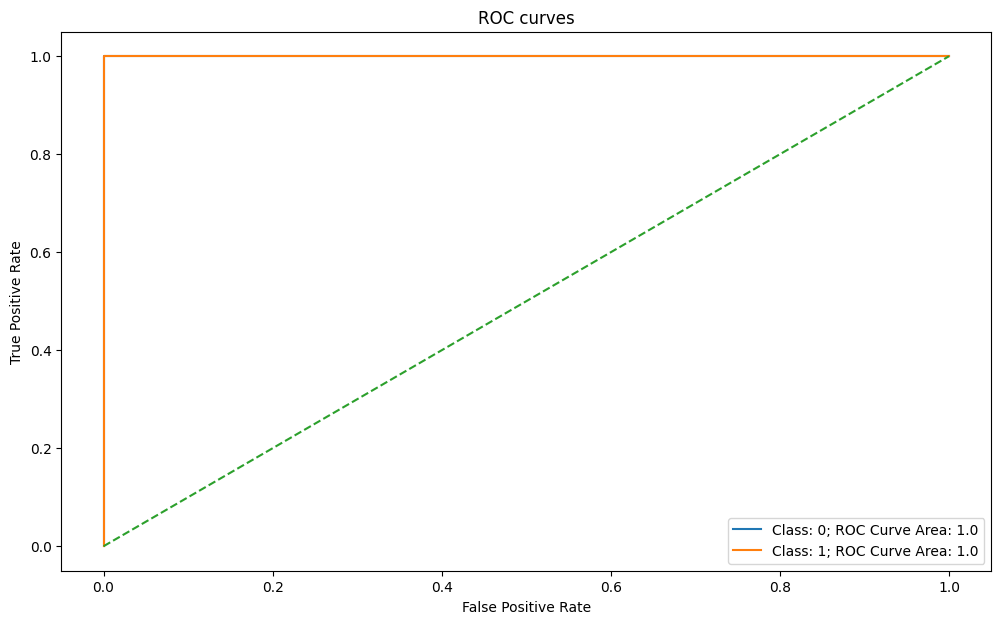

In [23]:
classification_and_roc_calculation(x_test, y_test, selected_features, isTest=True)

<b>Observation:</b>
<br>
The test accuracy is very similar to the cross-validation accuracy. 

#### vi. Separation

Do your classes seem to be well-separated to cause instability in calculating
logistic regression parameters?

<b>Observation:</b>
<br>
- Yes, the classes are completely separable, as can be seen in the summary description.
- It is possible that well-separated classes are causing the instability in the calculation of logistic regression parameters.

#### vii. Imbalance

From the confusion matrices you obtained, do you see imbalanced classes?
If yes, build a logistic regression model based on case-control sampling and
adjust its parameters. Report the confusion matrix, ROC, and AUC of the
model.

<b>Observation:</b>
<br>
- As per the confusion matrix for train data, we can see that 0 class has 69 instances, whereas 1 class has only 9 instances, which clearly indicates class imbalance.

In [24]:
# We have class imbalance as observed above, hence we will do oversampling.
print("\n========== NOTE ==========\nExecutingg logistic regression with oversampling\n")
cross_validation_factor = 5
pair_combinations = {
                     "pair(l, p)": [],
                     "score": []}

print("\n========== NOTE ==========\nExecuting Logistic Regression with l-values ∈ {1, 2, 3,. . ., 20}\n")
for l_val in tqdm(range(1, 21), desc="Progress"):
    model, selector = logistic_regression(train_files, l_val, cross_validation_factor, oversample=True)
    nf = selector.n_features_
    score = selector.cv_results_["mean_test_score"].max()
    pair_combinations["pair(l, p)"].append((l_val, nf))
    pair_combinations["score"].append(round(score, 3))

df = pd.DataFrame(pair_combinations).set_index("pair(l, p)")
df


========== NOTE ==========
Executingg logistic regression with oversampling


========== NOTE ==========
Executing Logistic Regression with l-values ∈ {1, 2, 3,. . ., 20}



Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [17:09<00:00, 51.47s/it]


score
pair(l, p)       
(1, 7)      1.000
(2, 5)      0.992
(3, 5)      1.000
(4, 13)     0.992
(5, 5)      1.000
(6, 10)     1.000
(7, 4)      1.000
(8, 4)      1.000
(9, 8)      1.000
(10, 5)     1.000
(11, 1)     0.992
(12, 8)     1.000
(13, 4)     1.000
(14, 3)     0.992
(15, 3)     0.992
(16, 4)     1.000
(17, 4)     1.000
(18, 3)     1.000
(19, 3)     1.000
(20, 7)     1.000


For l-value=1, set of selected features is: ['mean_1', '3rd_quartile_1', 'max_2', 'min_5', 'max_5', '1st_quartile_5'] 


Confusion Matrix:
 [[60  0]
 [ 0 60]]


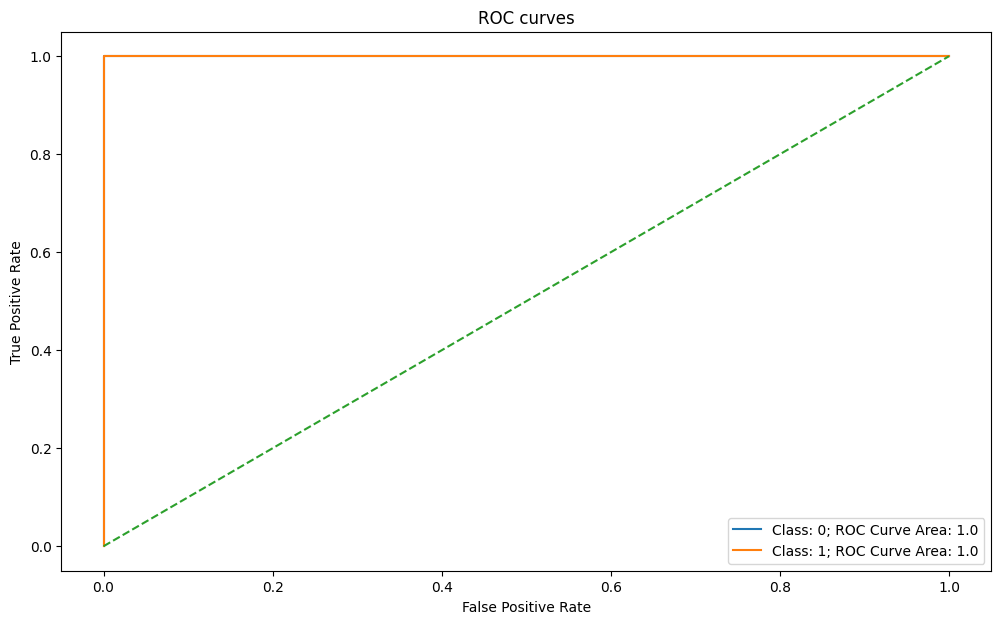

In [25]:
# Extracting the selected features as per l-value and fold count.
l_val = 1
fold_count = 5 
features = get_stats_columns(display_stats_columns, split_segments=l_val)
classifier, selector = logistic_regression(train_files, l_val, fold_count)
selected_features = get_selected_features(features, selector)
print("\nFor l-value=1, set of selected features is:", selected_features, "\n")

train_data = extract_feature_data(train_files, selected_features)
train_data = convert_text_labels_to_boolean(pd.DataFrame(train_data))
train_data = oversample_data(train_data)
x_train, y_train = get_x_y_data(train_data)
classification_and_roc_calculation(x_train, y_train, selected_features)

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

Repeat 2(a)iii using L1-penalized logistic regression,
i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem,
you have to cross-validate for both l, the number of time series into which you
break each of your instances, and λ, the weight of L1 penalty in your logistic
regression objective function (or C, the budget). Packages usually perform
cross-validation for λ automatically.


In [26]:
max_test_accuracy = 0
optimal_L = 1

# utility  method for performing regression based on the given classifier
def perform_classifier(classifier, classifier_name, l_val, kwargs, penalty="none", is_binary_classification=True, draw_roc=False):
    print(">>>Running {} for l-value {}".format(classifier_name, l_val))
    train_data = extract_feature_data(train_files, get_stats_columns(display_stats_columns, split_segments=l_val), split_segments=l_val)
    test_data = extract_feature_data(test_files, get_stats_columns(display_stats_columns, split_segments=l_val), split_segments=l_val)
    
    if is_binary_classification:
        train_data = get_column_labels_dataframe(train_data)
        test_data = get_column_labels_dataframe(test_data)
        
    x_train, y_train = get_x_y_data(train_data)
    x_test, y_test = get_x_y_data(test_data)
    
    if is_binary_classification:
        # https://stackoverflow.com/questions/45346550/valueerror-unknown-label-type-unknown
        y_train = y_train.astype("int")
        y_test = y_test.astype("int")
    
    classifier_2 = classifier(**kwargs)
    classifier_2.fit(x_train, y_train)
    
    if not draw_roc:    
        train_score = round(classifier_2.score(x_train, y_train), 3)
        test_score = round(classifier_2.score(x_test, y_test), 3)
        print("Value of L: {} | train_score: {} | test_score: {}".format(l_val, train_score, test_score))
        print("Value of L: {} | train_error: {} | test_error: {}\n".format(l_val, round((1 - train_score), 3), round((1 - test_score), 3)))
        global max_test_accuracy
        global optimal_L
        if test_score > max_test_accuracy:
            max_test_accuracy = test_score
            optimal_L = l_val
        
        if l_val == 20:
            print("The maximum accuracy is {} (for L-value: {})".format(max_test_accuracy, optimal_L))
            print("Hence, further calculations will be performed with l-value: {}".format(optimal_L))
        
    else:
        y_train_predict_proba = classifier_2.predict_proba(x_train)
        y_test_predict_proba = classifier_2.predict_proba(x_test)

        y_predict = classifier_2.predict(x_test)
        cf_mat = confusion_matrix(y_test, y_predict)
        print("Confusion matrix for test data:\n", cf_mat)
        
        print("ROC Curve for Train Data")
        plot_roc_auc(y_train, y_train_predict_proba, classifier_2)
        
        print("ROC Curve for Test Data")
        plot_roc_auc(y_test, y_test_predict_proba, classifier_2)

In [27]:
# making use of the varargs concept
kwargs = {"penalty" : "l1", "max_iter" : 100, "scoring" : "accuracy", "cv" : 5, "random_state" : 42, "solver" : "liblinear"}

fold_count = 5

# performing regression for each value of L for 20 iterations
for l_val in range(1, 21):
    perform_classifier(LogisticRegressionCV, "Logistic Regression", l_val, kwargs, penalty='none', is_binary_classification=True, draw_roc=False)

>>>Running Logistic Regression for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 1.0
Value of L: 1 | train_error: 0.0 | test_error: 0.0

>>>Running Logistic Regression for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 1.0
Value of L: 2 | train_error: 0.0 | test_error: 0.0

>>>Running Logistic Regression for l-value 3
Value of L: 3 | train_score: 1.0 | test_score: 1.0
Value of L: 3 | train_error: 0.0 | test_error: 0.0

>>>Running Logistic Regression for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.947
Value of L: 4 | train_error: 0.0 | test_error: 0.053

>>>Running Logistic Regression for l-value 5
Value of L: 5 | train_score: 1.0 | test_score: 1.0
Value of L: 5 | train_error: 0.0 | test_error: 0.0

>>>Running Logistic Regression for l-value 6
Value of L: 6 | train_score: 1.0 | test_score: 1.0
Value of L: 6 | train_error: 0.0 | test_error: 0.0

>>>Running Logistic Regression for l-value 7
Value of L: 7 | train_score: 1.0 | test_score: 0.947
Value of L

>>>Running Logistic Regression for l-value 1
Confusion matrix for test data:
 [[15  0]
 [ 0  4]]
ROC Curve for Train Data


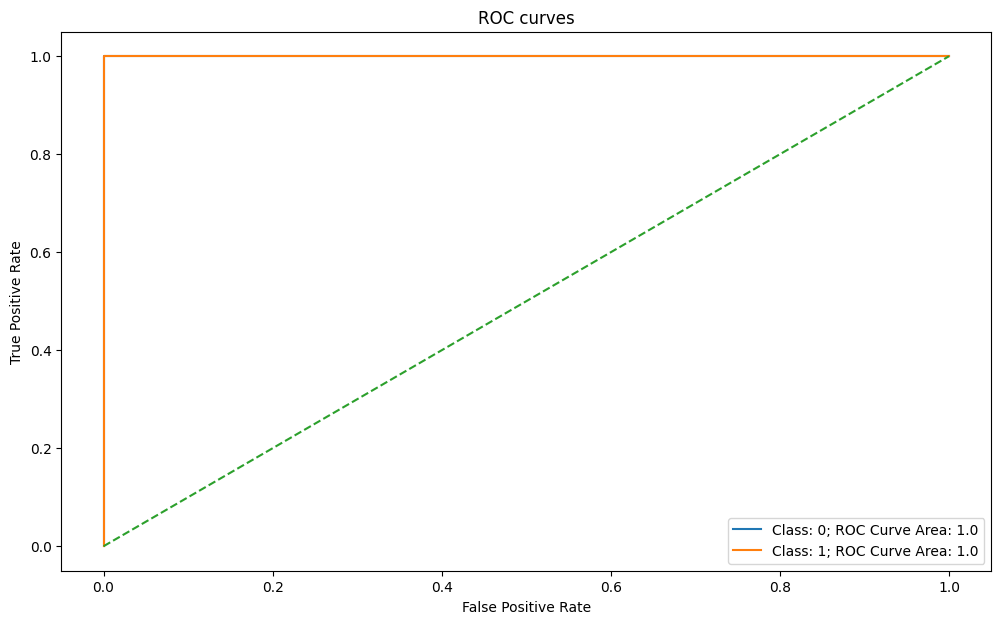

ROC Curve for Test Data


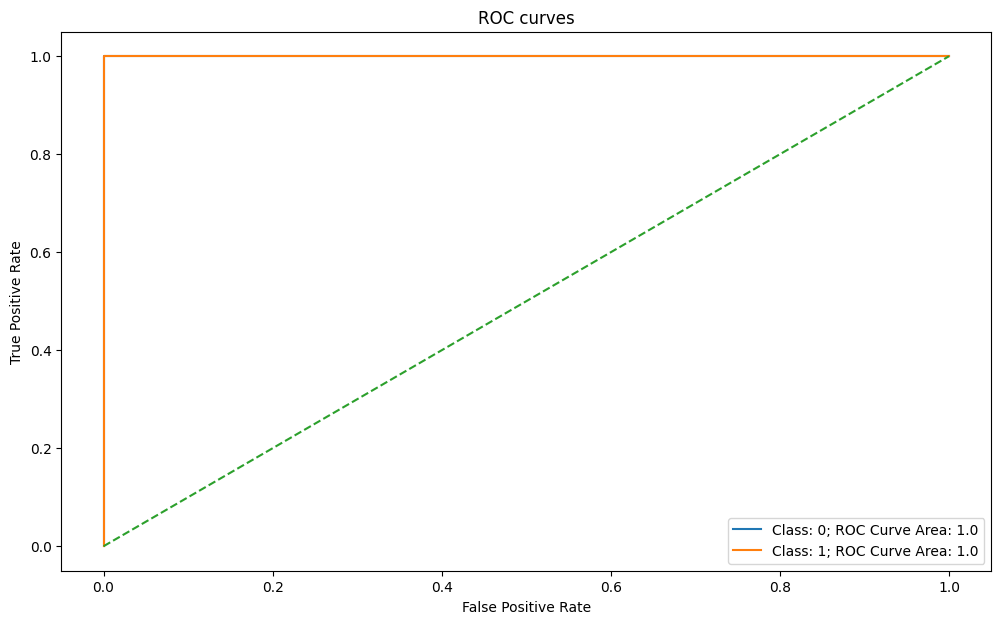

In [28]:
# making use of the varargs concept
kwargs = {"penalty" : "l1", "max_iter" : 100, "solver" : "liblinear"}

fold_count = 5
best_l = 1

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_classifier(LogisticRegression, "Logistic Regression", best_l, kwargs, penalty='none', is_binary_classification=True, draw_roc=True)

#### ii. Comparison

Compare the L1-penalized with variable selection using p-values. Which one
performs better? Which one is easier to implement?

<b>Observation:</b>
<br>
- The L1-penalized logistic regression has better performance in terms of accuracy when tested on the test data (approximately 1.0).
- The L1-regularization is easier to implement as feature selection does not need to be manual.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

Find the best l in the same way as you found it in 2(b)i to build an L1-
penalized multinomial regression model to classify all activities in your training set0 Report your test error. Research how confusion matrices and ROC
curves are defined for multiclass classification and show them for this problem
if possisble

In [29]:
# making use of the varargs concept
kwargs = {
    "penalty" : "l1", 
    "max_iter" : 100,
    "multi_class": "multinomial",
    "cv": 5,
    "random_state" : 42,
    "solver" : "saga"
}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

# performing regression for each value of L for 20 iterations
for l_val in range(1, 21):
    perform_classifier(LogisticRegressionCV, "Logistic Regression", l_val, kwargs, penalty="none", is_binary_classification=False, draw_roc=False)

>>>Running Logistic Regression for l-value 1
Value of L: 1 | train_score: 0.957 | test_score: 0.895
Value of L: 1 | train_error: 0.043 | test_error: 0.105

>>>Running Logistic Regression for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.947
Value of L: 2 | train_error: 0.0 | test_error: 0.053

>>>Running Logistic Regression for l-value 3
Value of L: 3 | train_score: 1.0 | test_score: 0.842
Value of L: 3 | train_error: 0.0 | test_error: 0.158

>>>Running Logistic Regression for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.895
Value of L: 4 | train_error: 0.0 | test_error: 0.105

>>>Running Logistic Regression for l-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.842
Value of L: 5 | train_error: 0.0 | test_error: 0.158

>>>Running Logistic Regression for l-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.789
Value of L: 6 | train_error: 0.0 | test_error: 0.211

>>>Running Logistic Regression for l-value 7
Value of L: 7 | train_score: 1.0 | test

>>>Running Logistic Regression for l-value 2
Confusion matrix for test data:
 [[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


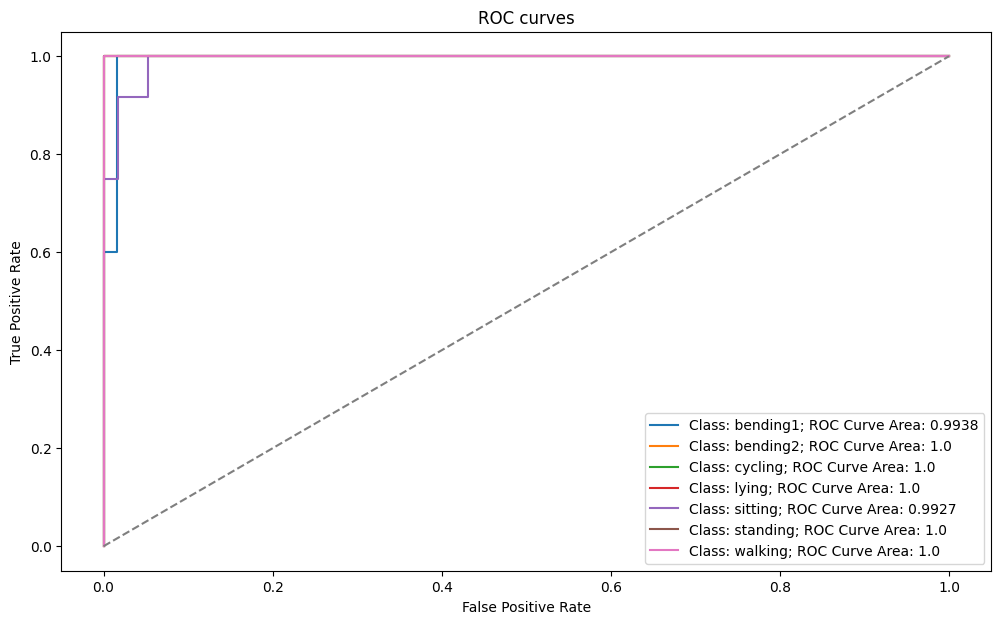

ROC Curve for Test Data


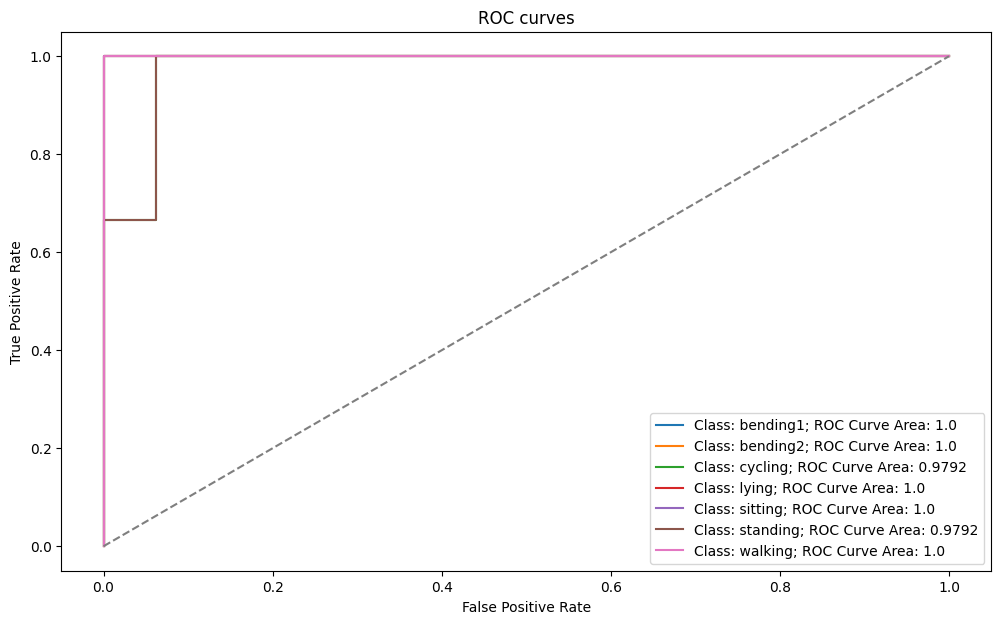

In [30]:
# making use of the varargs concept
kwargs = {"penalty" : "l1", "max_iter" : 100, "multi_class" : "multinomial","solver" : "saga"}

fold_count = 5
best_l = optimal_L

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_classifier(LogisticRegression, "Logistic Regression", best_l, kwargs, penalty="none", is_binary_classification=False, draw_roc=True)

#### ii. Naive Bayes

Repeat 2(c)i using a Naıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [31]:
kwargs = {}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

# performing regression for each value of L for 20 iterations
for l_val in range(1, 21):
    perform_classifier(GaussianNB, "Naive Bayes Classifier with Gaussian Prior", l_val, kwargs, penalty='none', is_binary_classification=False, draw_roc=False)

>>>Running Naive Bayes Classifier with Gaussian Prior for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.895
Value of L: 1 | train_error: 0.0 | test_error: 0.105

>>>Running Naive Bayes Classifier with Gaussian Prior for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.632
Value of L: 2 | train_error: 0.0 | test_error: 0.368

>>>Running Naive Bayes Classifier with Gaussian Prior for l-value 3
Value of L: 3 | train_score: 0.986 | test_score: 0.737
Value of L: 3 | train_error: 0.014 | test_error: 0.263

>>>Running Naive Bayes Classifier with Gaussian Prior for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.789
Value of L: 4 | train_error: 0.0 | test_error: 0.211

>>>Running Naive Bayes Classifier with Gaussian Prior for l-value 5
Value of L: 5 | train_score: 0.986 | test_score: 0.789
Value of L: 5 | train_error: 0.014 | test_error: 0.211

>>>Running Naive Bayes Classifier with Gaussian Prior for l-value 6
Value of L: 6 | train_score: 0.971 | test_score: 

>>>Running Naive Bayes Classifier with Gaussian Prior for l-value 1
Confusion matrix for test data:
 [[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


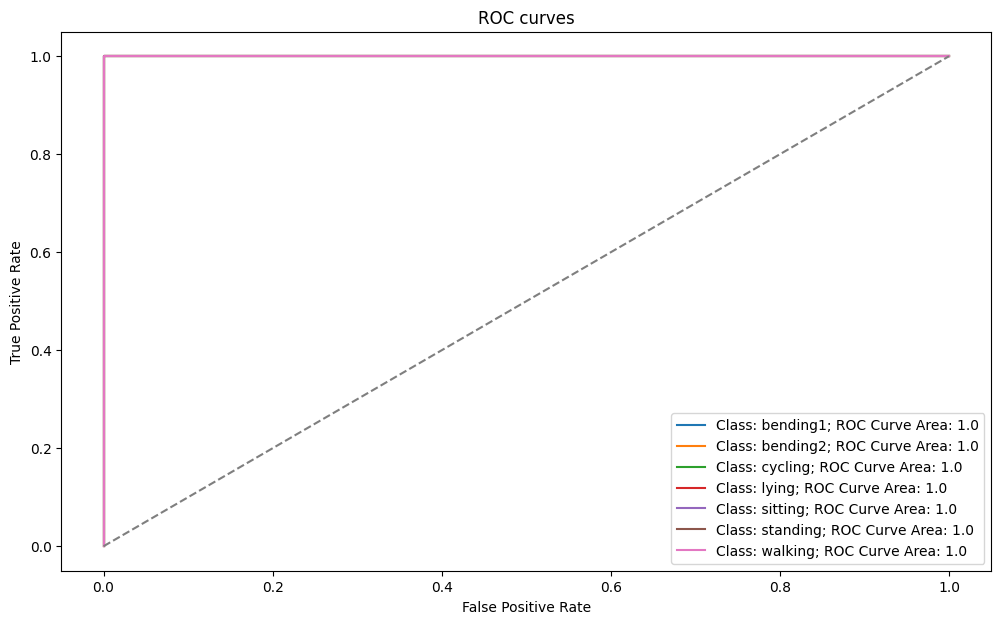

ROC Curve for Test Data


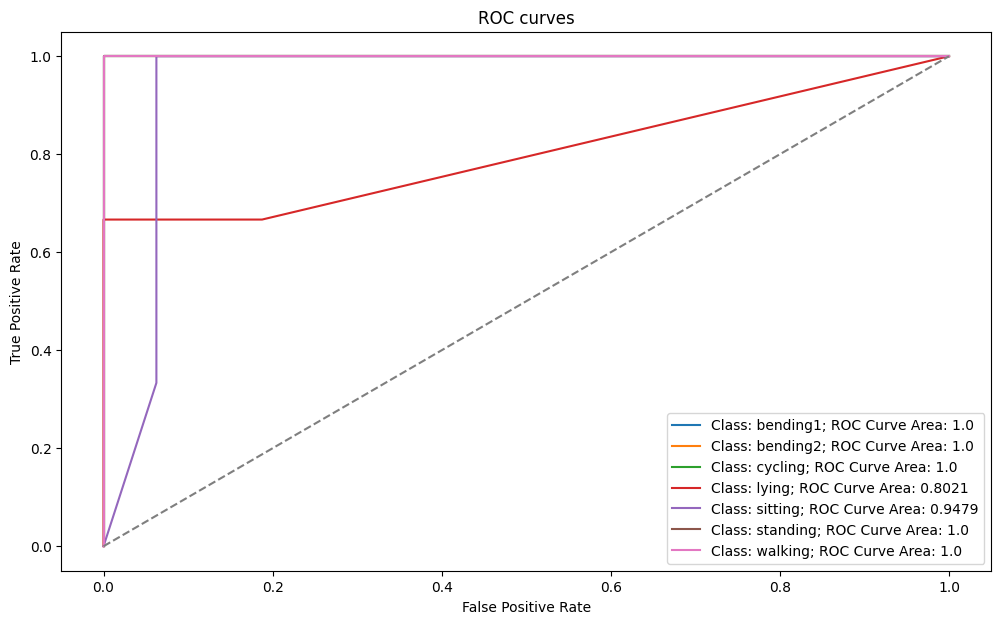

In [32]:
kwargs = {}

fold_count = 5
best_l = optimal_L

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_classifier(GaussianNB, "Naive Bayes Classifier with Gaussian Prior", best_l, kwargs, penalty="none", is_binary_classification=False, draw_roc=True)

In [33]:
kwargs = {}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

# performing regression for each value of L for 20 iterations
for l_val in range(1, 21):
    perform_classifier(MultinomialNB, "Naive Bayes Classifier with Multinomial Prior", l_val, kwargs, penalty="none", is_binary_classification=False, draw_roc=False)

>>>Running Naive Bayes Classifier with Multinomial Prior for l-value 1
Value of L: 1 | train_score: 0.928 | test_score: 0.895
Value of L: 1 | train_error: 0.072 | test_error: 0.105

>>>Running Naive Bayes Classifier with Multinomial Prior for l-value 2
Value of L: 2 | train_score: 0.884 | test_score: 0.737
Value of L: 2 | train_error: 0.116 | test_error: 0.263

>>>Running Naive Bayes Classifier with Multinomial Prior for l-value 3
Value of L: 3 | train_score: 0.899 | test_score: 0.789
Value of L: 3 | train_error: 0.101 | test_error: 0.211

>>>Running Naive Bayes Classifier with Multinomial Prior for l-value 4
Value of L: 4 | train_score: 0.913 | test_score: 0.789
Value of L: 4 | train_error: 0.087 | test_error: 0.211

>>>Running Naive Bayes Classifier with Multinomial Prior for l-value 5
Value of L: 5 | train_score: 0.928 | test_score: 0.737
Value of L: 5 | train_error: 0.072 | test_error: 0.263

>>>Running Naive Bayes Classifier with Multinomial Prior for l-value 6
Value of L: 6 | tra

>>>Running Naive Bayes Classifier with Multinomial Prior for l-value 1
Confusion matrix for test data:
 [[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


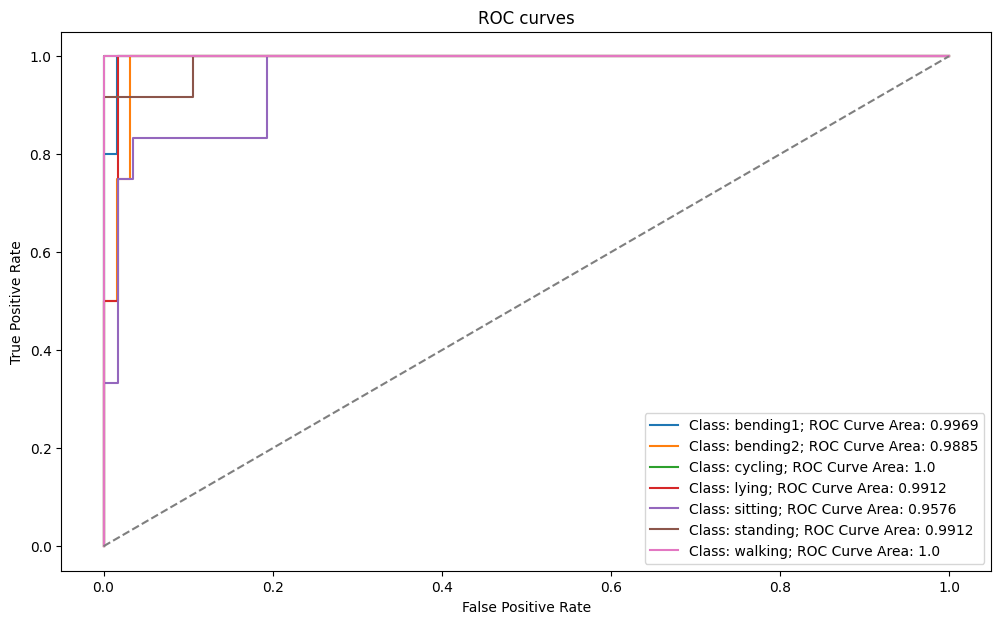

ROC Curve for Test Data


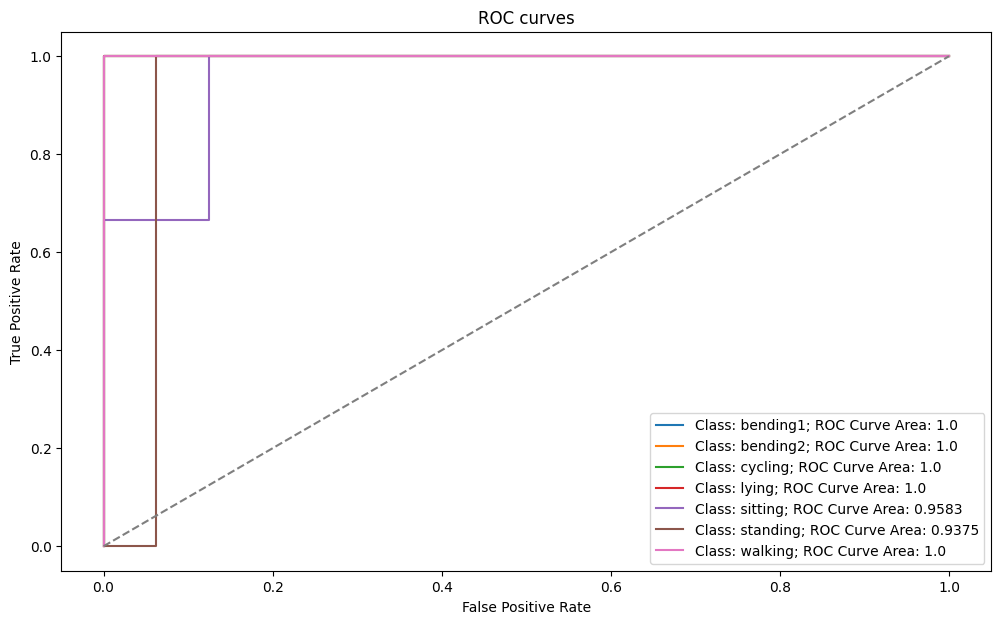

In [34]:
kwargs = {}

fold_count = 5
best_l = optimal_L

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_classifier(MultinomialNB, "Naive Bayes Classifier with Multinomial Prior", best_l, kwargs, penalty="none", is_binary_classification=False, draw_roc=True)

#### ii. Comparison

Which method is better for multi-class classification in this problem?

<b>Observation:</b>
<br>
Clearly, if we see all the ROC curves, we can observe that the ROC AUC for the Logistic Regression curve is better than any other classifer prior (Gaussian or Multinomial). Hence, Logistic Regression performs better in this problem.

<b>References and Citations:</b>
<br>
1) https://www.tutorialspoint.com/python/os_walk.htm
2) https://docs.python.org/3/library/csv.html
3) https://www.geeksforgeeks.org/python-os-path-dirname-method/
4) https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
5) https://www.tutorialspoint.com/numpy/numpy_concatenate.htm
6) https://acclab.github.io/bootstrap-confidence-intervals.html
7) https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html
8) https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
9) https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
10) https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
11) https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
12) https://scikit-learn.org/stable/modules/cross_validation.html
13) https://scikit-learn.org/stable/modules/naive_bayes.html